In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import math
import torch
import matplotlib.pyplot as plt

In [2]:
def make_betas(min=0.001, max=0.999, T=10):
    return torch.linspace(torch.tensor(min), torch.tensor(max), steps=T)

In [3]:
def q(x_t_1: torch.Tensor, beta_t: float):
    """
    Sample x_t ~ N(mu, beta_t I) with mu = sqrt(1-beta_t) * x_{t-1}.
    Returns: x_t, mu, sigma (scalar std)
    """
    beta = torch.as_tensor(beta_t, device=x_t_1.device, dtype=x_t_1.dtype)
    mu = torch.sqrt(1.0 - beta) * x_t_1
    eps = torch.randn_like(x_t_1)
    x_t = mu + torch.sqrt(beta) * eps
    
    return x_t, mu, torch.sqrt(beta)


In [25]:
def noise(x_0, T=100):
    betas = make_betas(T=T, max=0.01)
    xs = [x_0]
    mus = [x_0]
    stds = [torch.zeros((2,2))]
    for t, beta_t in zip(range(T), betas):
        x_t_1 = xs[-1]
        x_t, mu, std = q(x_t_1, beta_t)
        xs.append(x_t); mus.append(mu); stds.append(std)

    return torch.stack(xs)

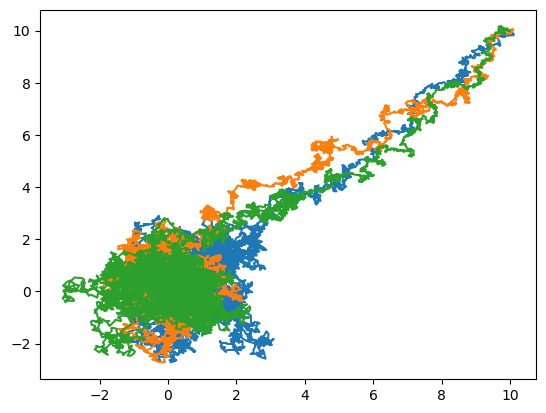

In [29]:
xs = torch.stack([noise(torch.tensor([10.,10.]), T=10_000) for _ in range(3)])

for path in xs: 
    plt.plot(*path.T)

In [33]:
def q_cf(x0, eps, t, betas):
    """
    One-shot sampling from q(x_t | x0) for DDPM.
    t: int (0-based) or tensor of indices.
    betas: 1D tensor shape [T]
    """
    betas = betas.to(x0.device).type_as(x0)
    alphas = 1.0 - betas
    alpha_bar = torch.cumprod(alphas, dim=0)  # [T]

    # handle scalar t
    abar_t = alpha_bar[t]

    x_t = torch.sqrt(abar_t) * x0 + torch.sqrt(1.0 - abar_t) * eps
    return x_t


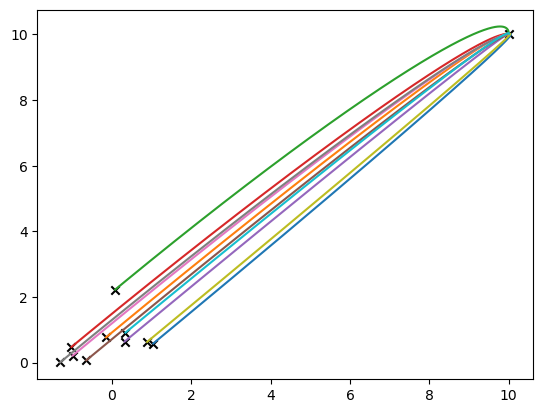

In [54]:
T = 3_000
x_0 = torch.tensor([10.,10.])
betas = make_betas(T=T, max=0.01)
eps = torch.randn_like(x_0)

def get_path(eps):
    return torch.stack([q_cf(x_0, eps, t=t, betas=betas) for t in range(T)])

epss = torch.randn(10, len(x_0))
paths = [get_path(eps) for eps in epss]

for path, eps in zip(paths, epss):
    plt.plot(*path.T)
    plt.scatter(*eps, marker='x', c='black')

plt.scatter(*x_0, marker='x', c='black')